# Classifier Comparison

In this example we show how **Concrete ML** classifiers can be used in a manner that is very 
similar to scikit-learn classifiers. FHE classifiers have an API that builds upon the scikit-learn 
API, adding two new elements:

* compiling the model to FHE
* predicting in FHE or with FHE simulation

The FHE classifiers, which quantize the inputs and model parameters, can be tested in a simulation
mode which shows the FHE effects on their accuracy. This type of execution is much faster than running in
FHE, but it does not operate over encrypted data. Simulation is very useful to 
design and train FHE compatible classifiers, as it allows the user to investigate whether the FHE
constraints are met at design time.

### FHE runtime considerations and simulation

In this demo the test data is classified in FHE and the decision function values for the domain
grid are computed using simulation. Thus:

* the accuracy reported is computed in FHE
* the red/blue decision function contours are computed with simulation

However, since the runtimes in FHE are high (it can take up to an hour to run test set 
classification in FHE), you have the option to run everything in simulation by 
setting ALWAYS_USE_SIM=True in the [utils/classifier_comparison_utils.py](utils/classifier_comparison_utils.py) file. 

In [1]:
# Source:
#   https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# Modified to integrate Concrete ML functions by Zama
# License: BSD 3 clause

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from functools import partial

import torch

from concrete.ml.sklearn import (
    DecisionTreeClassifier,
    LinearSVC,
    LogisticRegression,
    NeuralNetClassifier,
    RandomForestClassifier,
    XGBClassifier,
)

In [2]:
# The simulation mode allows to measure the impact of FHE execution on accuracy
# without paying the cost of FHE computations.
# However, data is not encrypted when using the simulation: the model performs inference
# on clear data.
%run utils/classifier_comparison_utils.py

### Neural-net-based classifiers

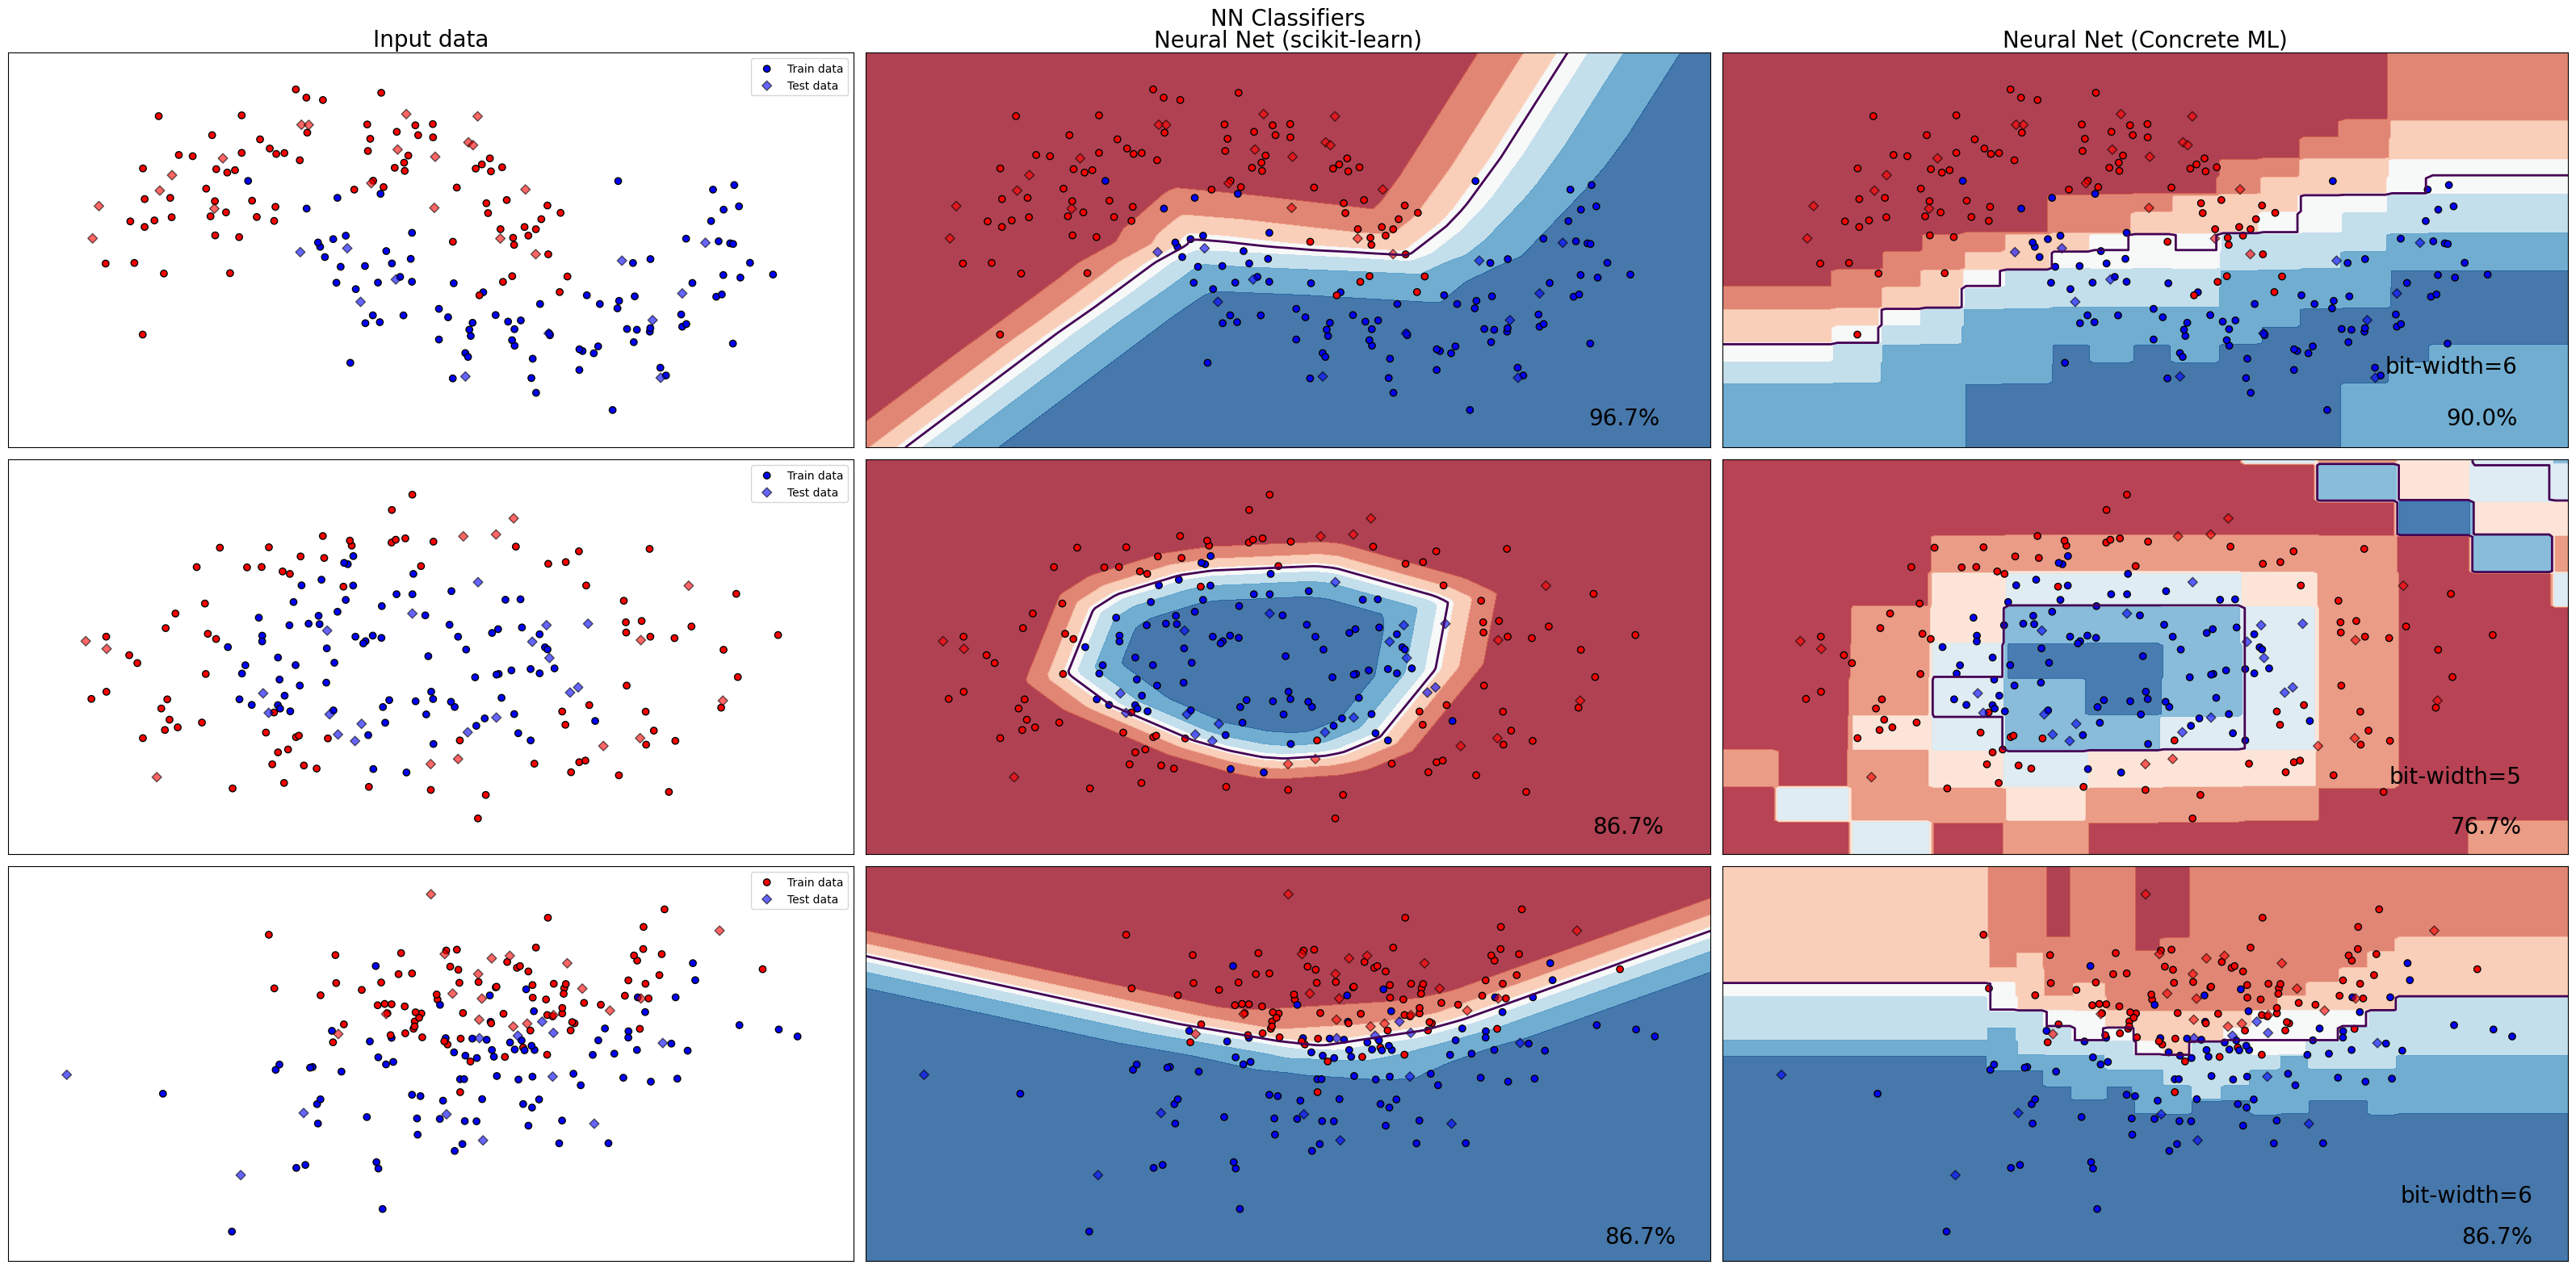

In [3]:
params_neural_net = {
    "module__n_w_bits": 2,
    "module__n_a_bits": 4,
    "module__n_accum_bits": 32,
    "module__n_hidden_neurons_multiplier": 6,
    "module__n_layers": 2,  # 1 hidden layer
    "module__activation_function": torch.nn.ReLU,
    "max_epochs": 400,
    "verbose": 0,
    "lr": 0.001,
}

neural_network_classifiers = [
    (
        partial(NeuralNetClassifier, batch_size=32, **params_neural_net),
        "Neural Net",
    ),
]

# pylint: disable-next=undefined-variable
make_classifier_comparison("NN Classifiers", neural_network_classifiers, 0.5)  # noqa

### Linear classifiers

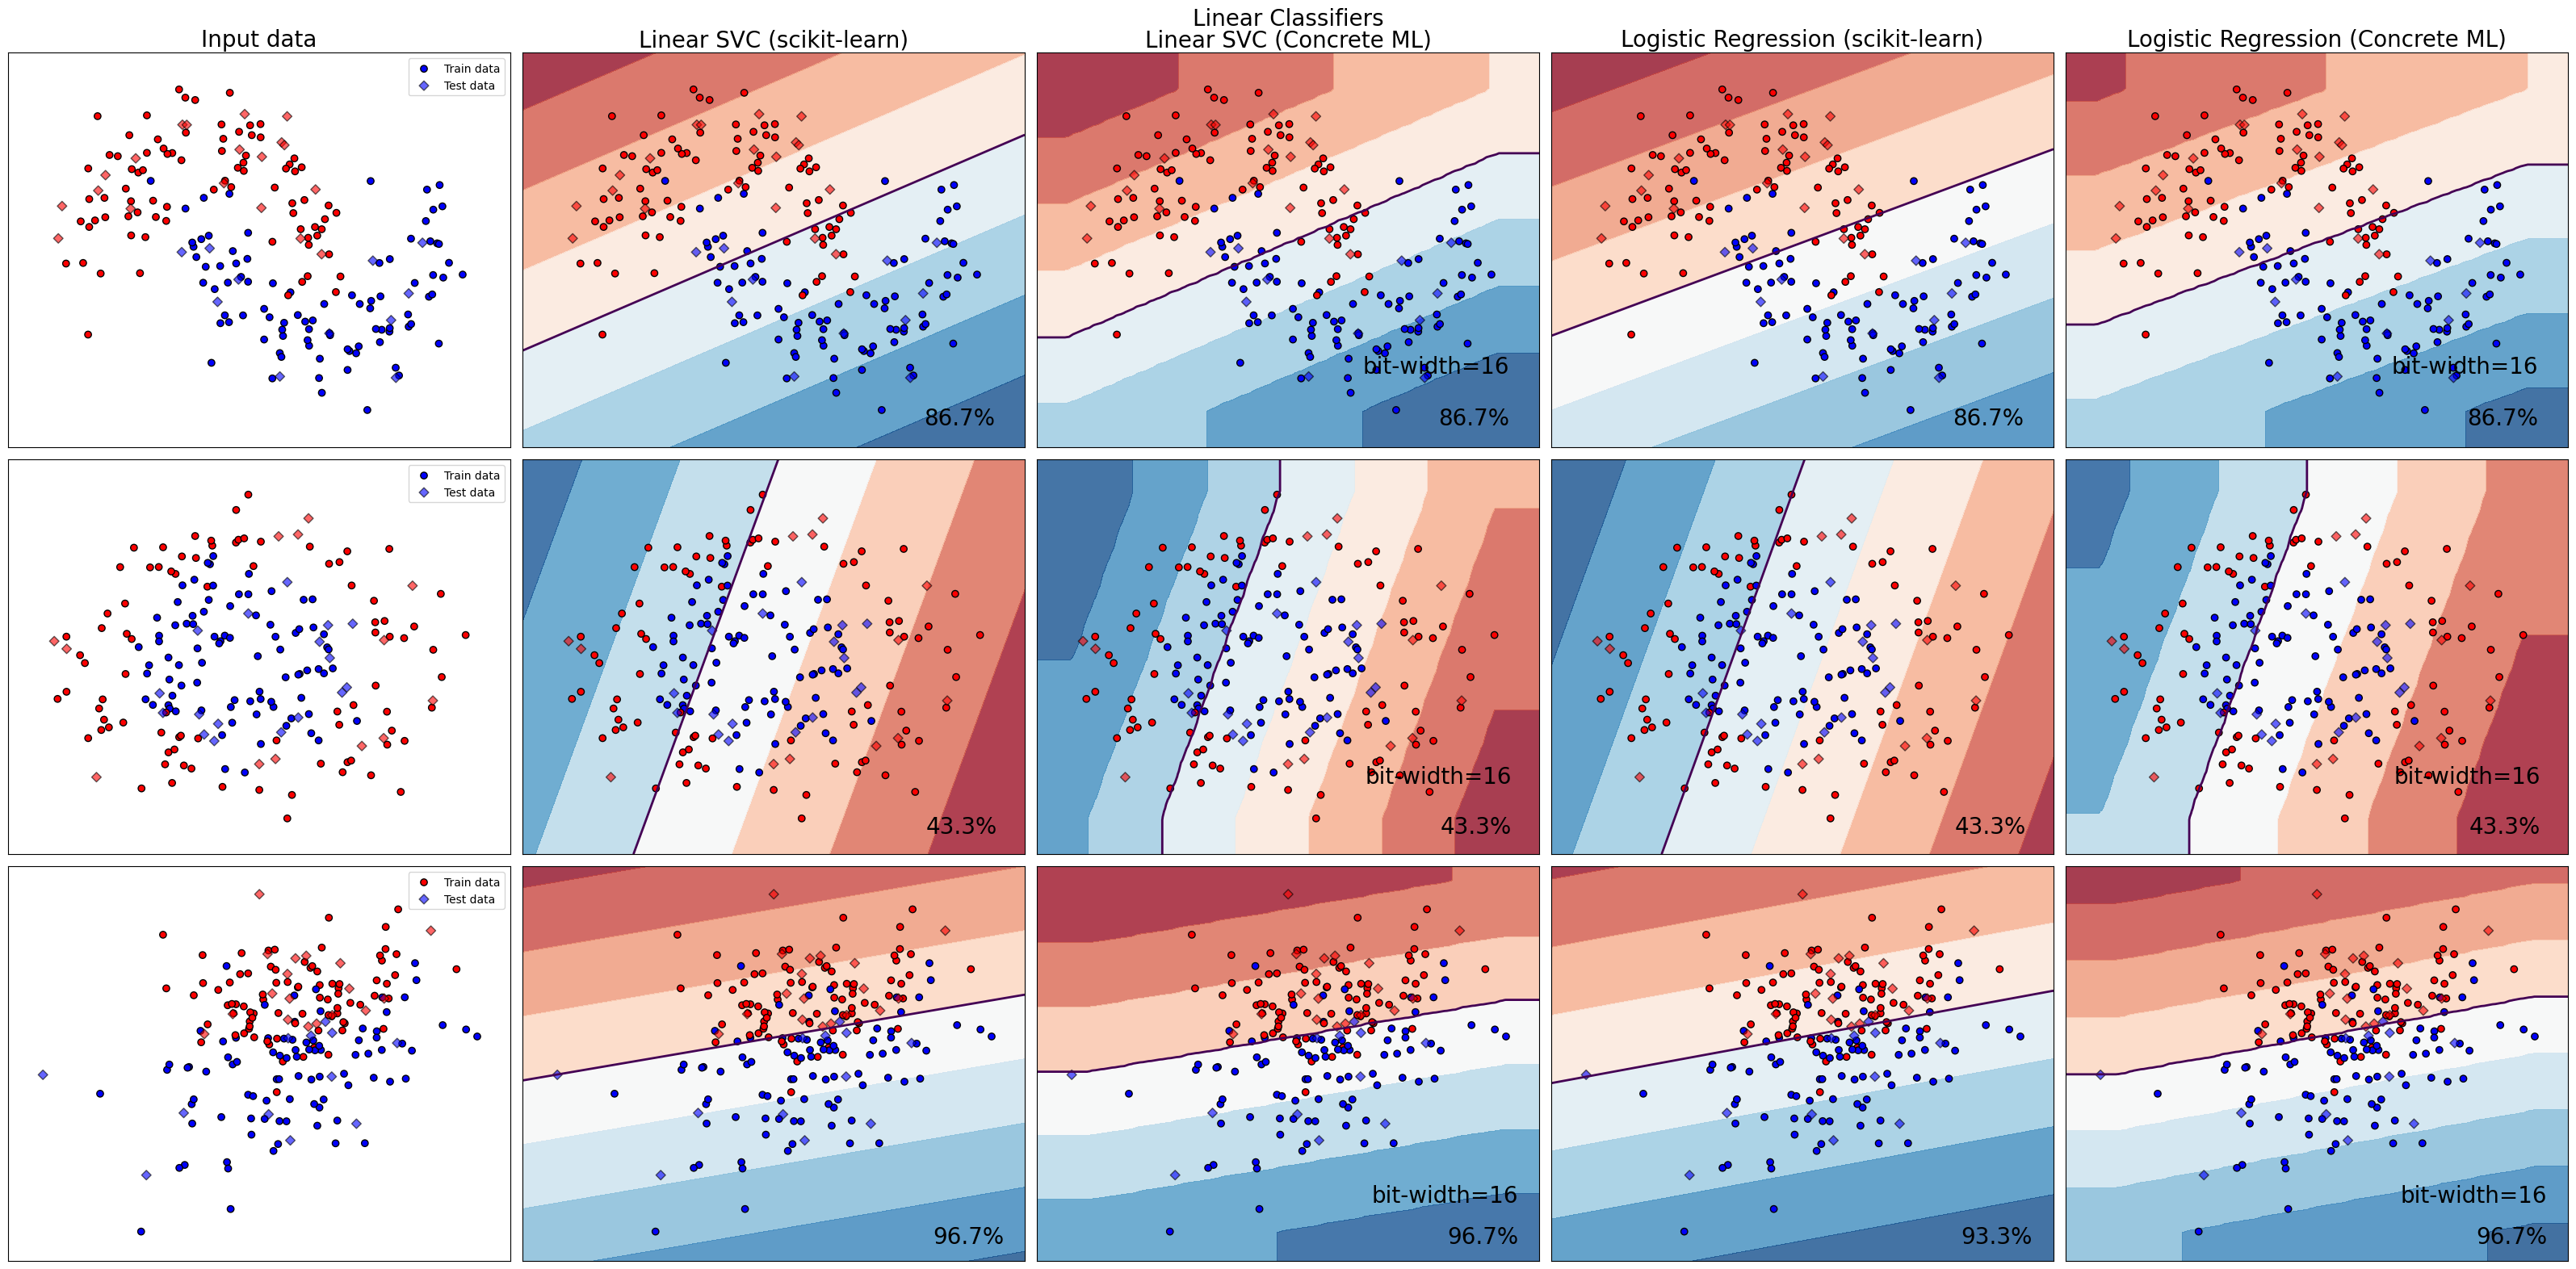

In [4]:
linear_classifiers = [
    (partial(LinearSVC, C=0.025), "Linear SVC"),
    (LogisticRegression, "Logistic Regression"),
]

# pylint: disable-next=undefined-variable
make_classifier_comparison("Linear Classifiers", linear_classifiers, 0)  # noqa

### Tree and tree ensemble classifiers

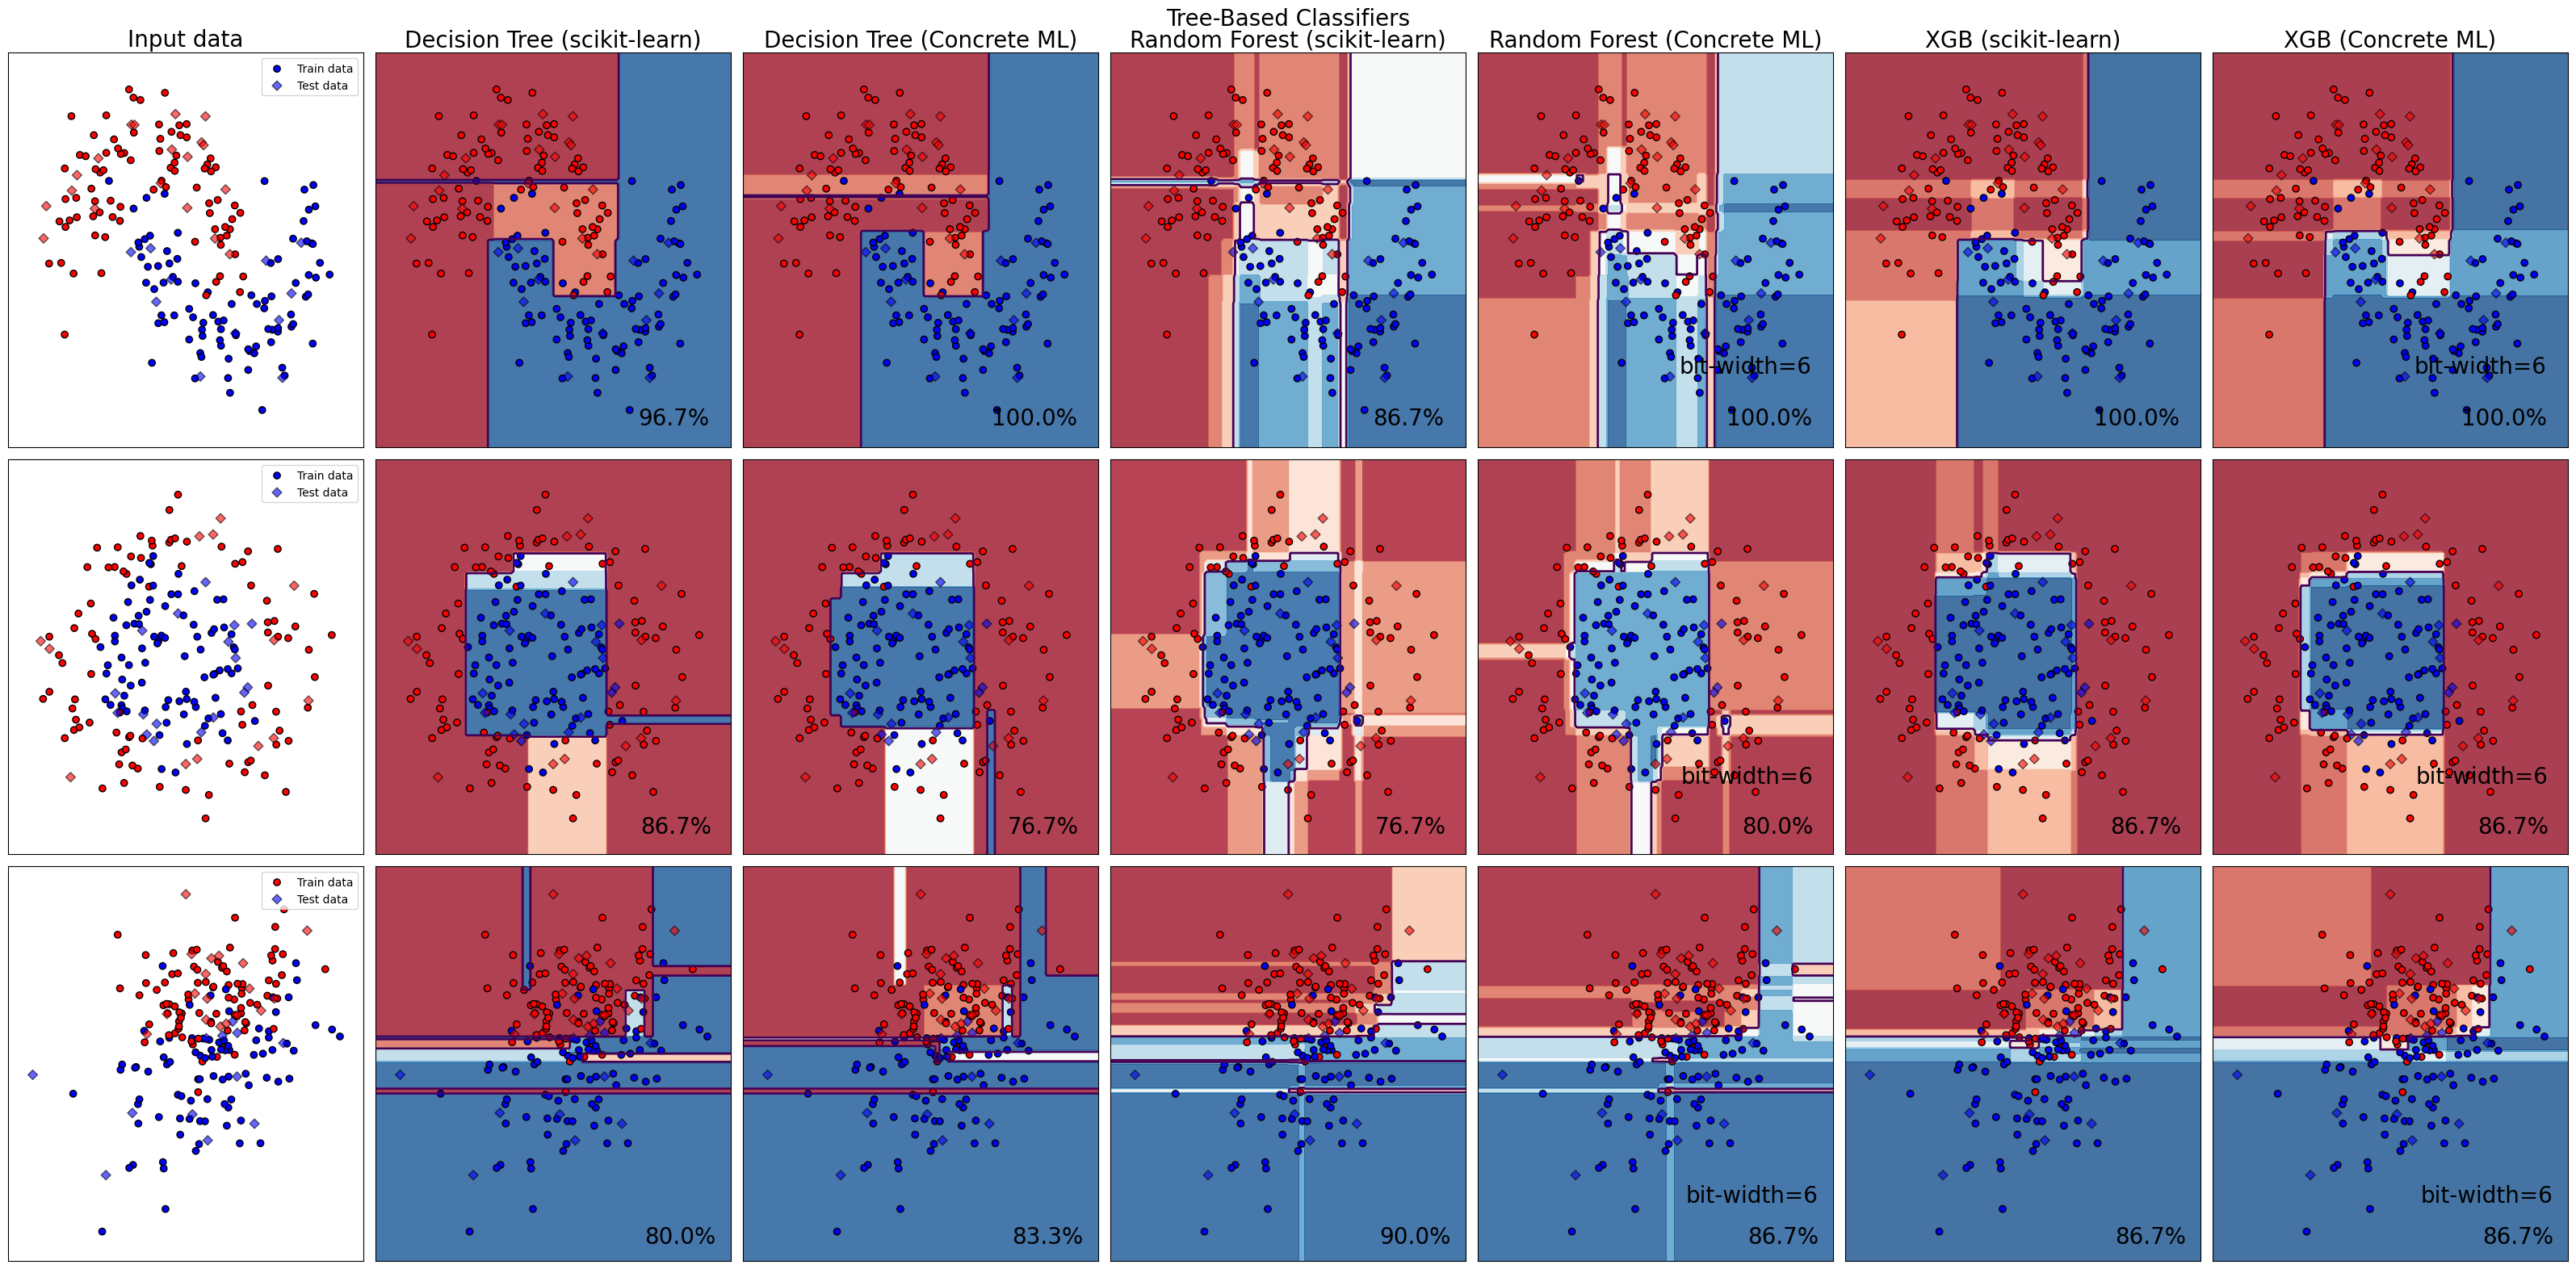

In [5]:
tree_classifiers = [
    (partial(DecisionTreeClassifier, max_depth=5), "Decision Tree"),
    (partial(RandomForestClassifier, max_depth=4, n_estimators=5), "Random Forest"),
    (partial(XGBClassifier, n_jobs=1, max_depth=4, n_estimators=5), "XGB"),
]

# pylint: disable-next=undefined-variable
make_classifier_comparison("Tree-Based Classifiers", tree_classifiers, 0.5)  # noqa

## Conclusion

In this example we showed the results of three types of classifiers: 

* linear (Support Vector Machine, Logistic Regression)
* neural-networks (multi-layer non-linear models)
* tree-based (Decision Tree, Random Forest, XGBoost)

The accuracy of the **Concrete** classifiers is measured on encrypted data. These classifiers 
work with parameters and inputs that are heavily quantized and, thus, show accuracy loss:
* linear models: linear models in FHE have good performance and are fast. These models are accurate 
as they require very little quantization. Their performance is identical to that of their fp32 counterparts
* neural networks: as seen above, neural networks have good performance in FHE despite being 
subjected to heavy quantization thanks to Quantization Aware Training (QAT) techniques
* tree-based classifiers: these classifiers achieve good accuracy both in fp32 and in quantized 
mode in FHE on encrypted data. Due to the particular computations in tree-based models, performance 
in FHE is maintained at the fp32 levels even on data-sets which have a much higher number of 
dimensions

## Future work

In future releases of **Concrete ML** we will include the K-nearest neighbors classifier to this notebook.